# Dataset preparing 

In [1]:
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform
from tqdm import tqdm

plt.style.use('seaborn-deep')
np.random.seed(42)

In [2]:
'''
Define data folders 
'''
train_dir = './data/train'
test_dir = './data/test'

train_images_dir = os.path.join(train_dir, 'images')
train_masks_dir = os.path.join(train_dir, 'masks')

test_images_dir = os.path.join(test_dir, 'images')
test_masks_dir = os.path.join(test_dir, 'masks')

imageinfo_filename = './ISIC/imagedata.csv' # Info for all images 
maskinfo_filename = './ISIC/masksdata.csv'

In [3]:
'''Load metadata'''
image_info = pd.read_csv(imageinfo_filename)
mask_info = pd.read_csv(maskinfo_filename)

print('Datasets:\n',list(image_info['dataset_name'].unique()))

Datasets:
 ['UDA-1', 'UDA-2', 'MSK-2', 'MSK-1', 'MSK-3', 'MSK-4', 'MSK-5', 'Dermoscopedia (CC-BY)', '2018 JID Editorial Images', 'HAM10000']


In [4]:
'''
Create a class for our dataset
'''
class ISICDataset(Dataset):
    '''ISIC images-masks dataset'''
    def __init__(self, images_dir, masks_dir, transform=None):
        '''
        Args:
            imgs_dir (string): Directory with all images
            mask_dir (string): Directory with all masks
            transform (callable, optional): Optional transform to be applied on a sample.
        '''
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
    
    def __len__(self):
        return len(os.listdir(self.masks_dir))
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        image_filename = sorted(os.listdir(self.images_dir))[index]
        mask_filename = sorted(os.listdir(self.masks_dir))[index]

        image = io.imread(os.path.join(self.images_dir,image_filename))
        mask = io.imread(os.path.join(self.masks_dir,mask_filename))
        
        sample = {'image': image, 'mask': mask}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
        

In [8]:
'''
Example of work ISICDataset class
'''
train_isic_dataset = ISICDataset(train_images_dir, train_masks_dir)


/home/ivan/tools/anaconda3/envs/dcv/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


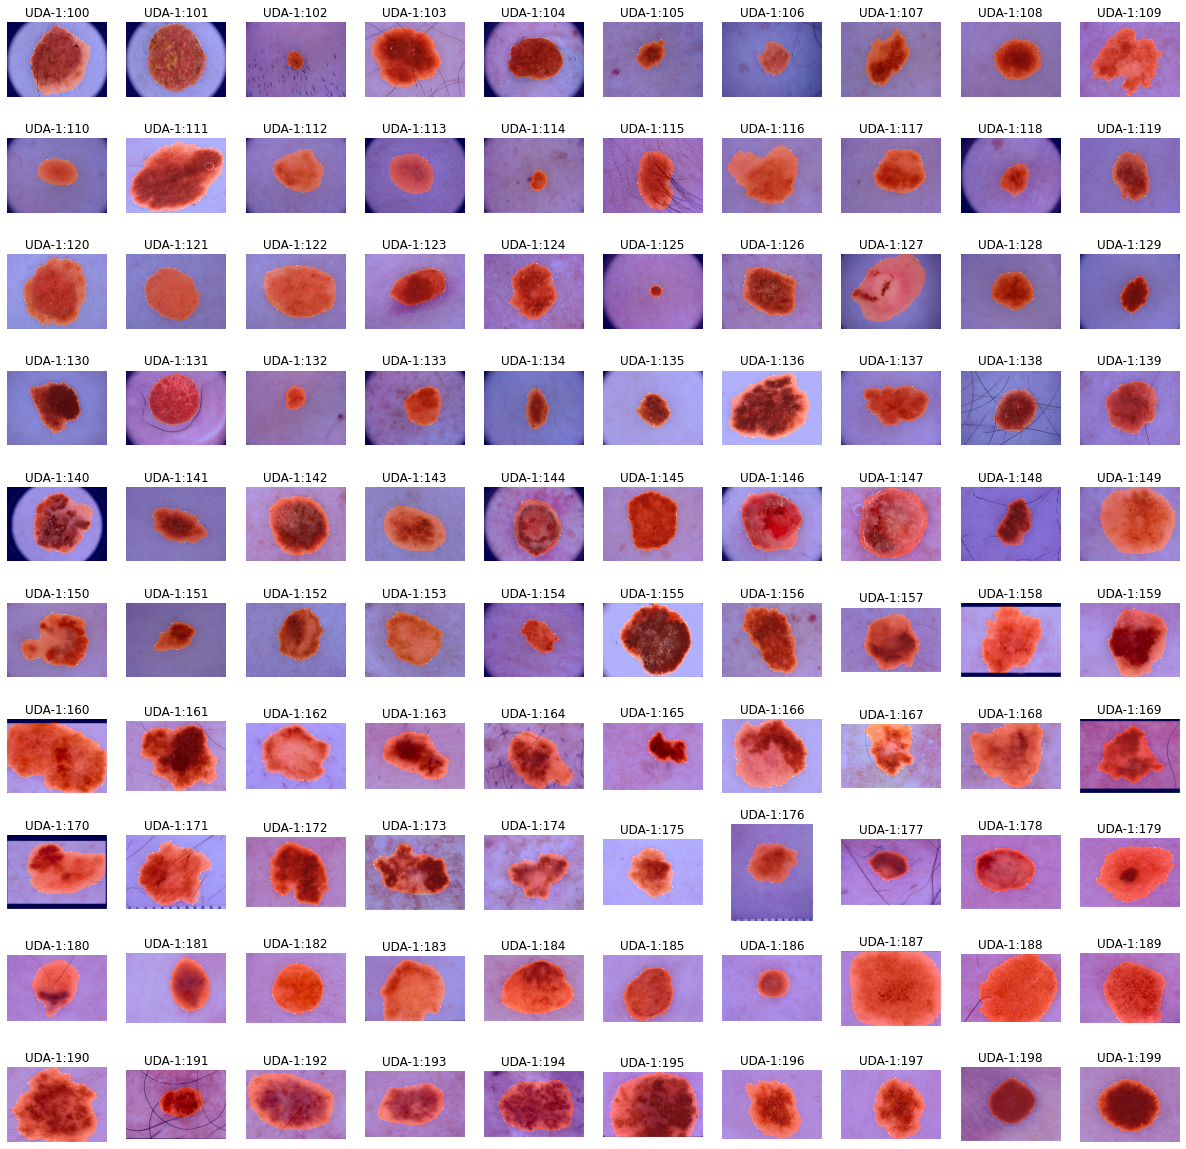

In [59]:

w_images = 10
h_images = 10

fig, ax = plt.subplots(w_images,h_images, figsize=(21,21))

index = 100
for i in range(w_images):
    for j in range(h_images):
        sample = train_isic_dataset[index]
        
        ax[i,j].imshow(sample['image'])
        ax[i,j].imshow(sample['mask'], 'bwr', alpha=0.3, vmax=1,vmin=0)
        ax[i,j].axis('off')
        ax[i,j].set_title(image_info['dataset_name'][index] + ':' + str(index))
        
        index += 1
        
fig.show()

In [9]:
'''
Creating transforms
'''
class Rescale(object):
    '''Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    '''

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        
        h, w = sample['image'].shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        msk = transform.resize(mask, (new_h, new_w))
        msk = msk.round()
        
        return {'image': img, 'mask': msk}
    
    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]
        mask = mask[top: top + new_h, left: left + new_w]

        return {'image': image, 'mask': mask}
            
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        # .unsqueeze(0)
        return {'image': torch.tensor(image, dtype=torch.float),
                'mask': torch.tensor(np.ceil(mask), dtype=torch.long)}

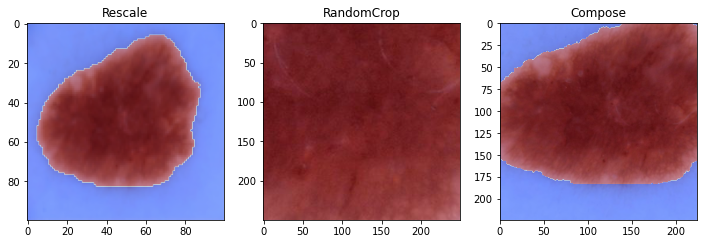

In [17]:
'''
Transformation demo
'''
scale = Rescale((100, 100))
crop = RandomCrop(250)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])
# Apply each of the above transforms on sample.
sample = train_isic_dataset[0]

fig, ax = plt.subplots(1,3, figsize=(12,6))

for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax[i].set_title(type(tsfrm).__name__)
    ax[i].imshow(transformed_sample['image'])
    ax[i].imshow(transformed_sample['mask'], 'bwr', alpha=0.3, vmax=1,vmin=0)
    
#     show_imgmask(transformed_sample['image'], transformed_sample['mask'], ax[i])

plt.show()

# Segmentation models

In [62]:
'''
Setup parameters
'''
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

n_epochs = 1
batch_size = 32
lr = 1e-4

models_names = ['unet', 'deeplabv3_resnet101']
model_name = models_names[0]

In [63]:
'''
Setup train/test datasets
'''
train_dataset = ISICDataset(train_images_dir, 
                        train_masks_dir,
                        transform=transforms.Compose([
                            Rescale((256,256)),
                            ToTensor()
                        ]))

test_datasetset = ISICDataset(test_images_dir, 
                       test_masks_dir,
                       transform=transforms.Compose([
                           Rescale((256,256)),
                           ToTensor()
                        ]))

# dataset for debug
n_imgs = 500
small_train_set, _ = random_split(train_dataset, [n_imgs, len(train_dataset)-n_imgs])

In [64]:
'''
Define Dataloaders
'''
train_params = {
    'batch_size': batch_size,
    'shuffle': True,
    'num_workers': 8,
    'drop_last': True
}
test_params = {
    'batch_size': 8,
    'shuffle': True,
    'num_workers': 8,
    'drop_last': True
}
train_loader = torch.utils.data.DataLoader(train_dataset, **train_params)
test_loader  = torch.utils.data.DataLoader(test_datasetset, **test_params)
# small_loader = torch.utils.data.DataLoader(small_train_set, **train_params)

In [13]:
'''
Load model
'''
print('Loading '+model_name+'...')
if model_name == 'unet':
    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                           in_channels=3, out_channels=1, init_features=32, pretrained=True)
    
elif model_name == 'deeplabv3_resnet101':
    model = torchvision.models.segmentation.deeplabv3_resnet101(num_classes=1)


model = model.to(device)
print('done.')

Loading unet...


Using cache found in /home/ivan/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


done.


In [14]:
'''
Optimizer and Loss function
'''
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [15]:
# test model output shape
model.eval()
output = model(torch.randn(1,3,256,256).to(device))
print(output.shape)

torch.Size([1, 1, 256, 256])


In [16]:
'''
Train the model
'''
def make_train_step(model, loss_fn, optimizer):
    def train_step(x,y):
        # set model to train mode
        model.train()
        # make predictions
        yhat = model(x)
        if model_name == 'deeplabv3_resnet101':
            yhat = yhat['out']
        #compute loss
        y = y.unsqueeze(1).to(device, dtype=torch.float32)
        loss = loss_fn(y, yhat)
        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.item()
    return train_step

train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(1):
    for i, sample in enumerate(train_loader):
        image, mask = sample['image'].to(device), sample['mask'].to(device)
    
        loss = train_step(image, mask)
        
        if (i+1)%10==0:
            print('Epoch[{}/{}], loss: {}'.format(epoch+1, n_epochs, loss))
print('done.')

Epoch[1/1], loss: 0.7738981246948242
Epoch[1/1], loss: 0.650559663772583
Epoch[1/1], loss: 0.6673780679702759
Epoch[1/1], loss: 0.6237530708312988
Epoch[1/1], loss: 0.6152124404907227
Epoch[1/1], loss: 0.6318743228912354
Epoch[1/1], loss: 0.6183056831359863
Epoch[1/1], loss: 0.6130410432815552
Epoch[1/1], loss: 0.5969634652137756
Epoch[1/1], loss: 0.5918633937835693
Epoch[1/1], loss: 0.60399329662323
done.


In [65]:
sample = next(iter(test_loader))
print('done.')

done.


In [67]:
sample['image'][0].unsqueeze(0).shape

torch.Size([1, 3, 256, 256])

In [90]:
index = 7
with torch.no_grad():
    model.eval()
    output = model(sample['image'][index].unsqueeze(0).to(device))
#     output = output['out']

In [91]:
untransform = transforms.ToPILImage()
in_img = untransform(sample['image'][index].unsqueeze(0).squeeze(0))
true_mask = sample['mask'][index].squeeze(0).numpy()
out_mask = untransform(output.cpu().clone().squeeze(0))


/home/ivan/tools/anaconda3/envs/dcv/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


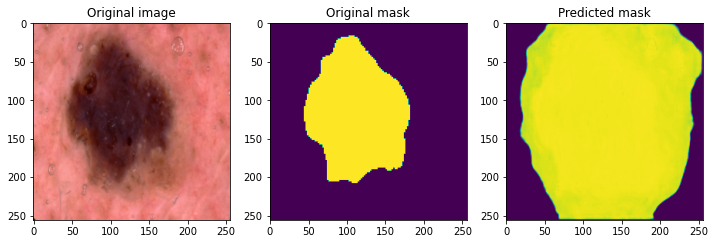

In [92]:
fig, ax = plt.subplots(1,3, figsize=(12,8))

ax[0].imshow(in_img)
ax[0].set_title('Original image')
ax[1].imshow(true_mask)
ax[1].set_title('Original mask')
ax[2].imshow(out_mask, vmax=255,vmin=0)
ax[2].set_title('Predicted mask')
fig.show()

In [94]:
msk = sample['mask'].unsqueeze(0).to(device, dtype=torch.float32)
loss_fn(output, msk)
# output.shape
# msk.shape

tensor(0.7198, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

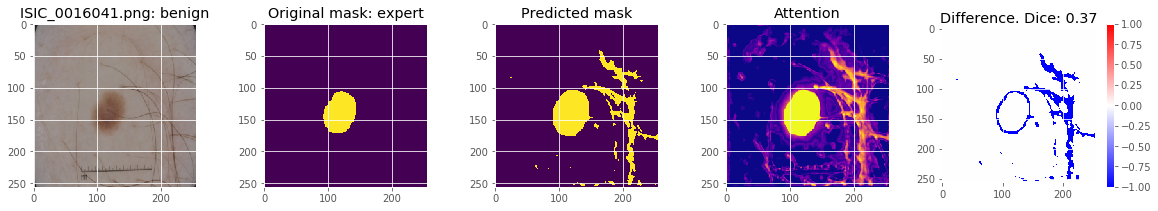

In [86]:
# Easy: 1128 1132 1135 1141
# Hard: 1181 1127 1131 1133
threshold_for_prediction = 0.0
index = 50
mask_index = 1

sample = test_set[index] 
image, mask = sample['image'], sample['mask']

# load masks
img = image.unsqueeze(0).to(device)
mask = mask.to(device)

# predict mask
y_pred = model(img)

# compute dice
output = y_pred[-1][mask_index]
output = (output > threshold_for_prediction).long()
target = mask
dice = torch_dice(output, target)

# info about image
diagnosis = image_info['benign_malignant'][index]
img_name = os.listdir(test_images_dir)[index]

# get true image and mask
true_img = image.detach().numpy().transpose(1,2,0)
true_mask = mask.detach().cpu().numpy()

# get predicted mask
pred_mask = y_pred.squeeze(0).clone()
pred_mask = pred_mask.detach().cpu().numpy().transpose(1,2,0)
npred_mask = np.array((pred_mask > threshold_for_prediction), dtype='int')

# plot
fig, ax = plt.subplots(1, 5, figsize=(20,3))

ax[0].imshow(true_img)
ax[0].set_title(img_name+': '+diagnosis)
ax[1].imshow(true_mask)
ax[1].set_title('Original mask: {}'.format(mask_info['skill'][index]))
ax[2].imshow(npred_mask[:,:,mask_index])
ax[2].set_title('Predicted mask')
ax[3].imshow(pred_mask[:,:,mask_index], 'plasma', vmin=-1,vmax=1)
ax[3].set_title('Attention')
im = ax[4].imshow(true_mask - npred_mask[:,:,mask_index], 'bwr', vmin=-1,vmax=1)
ax[4].set_title('Difference. Dice: {:2.2f}'.format(1 - dice.item()))
plt.colorbar(im)
plt.show()

In [180]:
'''
TEST
'''
total_dice_score = 0.0
threshold_for_prediction = 0.0 # between(-1,1); try: 0 and 0.999

with torch.no_grad():
    for i in range(907): # 907 test images
        sample = test_set[i]
        image, mask = sample['image'], sample['mask']

        # [N, 3, H, W] - image
        # [N, H, W] - mask with classes (0, 1)
        img = image.unsqueeze(0).to(device)
        msk = mask.unsqueeze(0).to(device)

        y_pred = model(img)
        
        # Compute Dice
        output = y_pred[-1][1]
        target = msk[-1]

        output = (output > threshold_for_prediction).long()
        
        dice = torch_dice(output, target)
        total_dice_score += dice.item()
        
        if i % 10 == 9:
            print(i, total_dice_score / i)

print('-'*25)
print('0 - same; 1 - different')    
print('Total test dice loss: {:2.6f}'.format(total_dice_score / 500))
